# IDH

#### Fontes

Municípios: http://www.pnud.org.br/atlas/ranking/Ranking-IDHM-Municipios-2010.aspx

Estados: http://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_IDH


In [106]:
%matplotlib inline
import pandas as pd
import requests as req
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.regression.linear_model import OLSResults
from patsy import dmatrix

np.set_printoptions(precision=3)

### Carregando dados de IDH-M da Wikipedia

In [2]:
url = 'http://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_IDH'

In [3]:
html_text = req.get(url).text

In [4]:
table = pd.read_html(html_text, attrs={"class":"wikitable"})[0]

In [5]:
def idh_format(str):
    num = float(str)/1000.0
    return num

### Pré-Processando IDH-M Data

In [6]:
"""
  0,800 – 1 (Muito alto) - idh_level = 0
  0,700 - 0,799 (Alto)   - idh_level = 0
  0,600 - 0,699 (Médio)  - idh_level = 1
  0,500 - 0,599 (Baixo)  - idh_level = 2
  0 - 0,499 (Muito baixo)- idh_level = 3
"""
def idh_level(x):
    if x >= 0.7:
        return 0
    elif 0.6 <= x < 0.7:
        return 1
    elif 0.5 <= x < 0.6:
        return 2
    elif 0.4 <= x < 0.5:
        return 3
    else: raise Exception("Invalid!")
    
"""
  Abaixo da mediana de 2000 = level 0
  Igual ou acima da mediana de 2000 = level 1
"""
def idh_level2(x):
    if x >= table[4][2:].apply(idh_format).median():
        return "ALTO"
    else: return "BAIXO"   


In [7]:
idhm_df = pd.DataFrame({u'Estado':table[2][2:].tolist(),u'I2010':table[3][2:].apply(idh_format).tolist(),u'I2000':table[4][2:].apply(idh_format).tolist()})
idhm_df["Ratio"] = idhm_df["I2010"]/idhm_df["I2000"]
idhm_df["idh_level_2000"] = idhm_df["I2000"].apply(idh_level2)

In [8]:
idhm_df

,Estado,I2000,I2010,Ratio,idh_level_2000
0,Distrito Federal,0.725,0.824,1.136552,ALTO
1,São Paulo,0.702,0.783,1.115385,ALTO
2,Santa Catarina,0.674,0.774,1.148368,ALTO
3,Rio de Janeiro,0.664,0.761,1.146084,ALTO
4,Paraná,0.650,0.749,1.152308,ALTO
5,Rio Grande do Sul,0.664,0.746,1.123494,ALTO
6,Espírito Santo,0.640,0.740,1.156250,ALTO
7,Goiás,0.615,0.735,1.195122,ALTO
8,Minas Gerais,0.624,0.731,1.171474,ALTO
9,Mato Grosso do Sul,0.613,0.729,1.189233,ALTO


### Análise Descritiva

In [9]:
idhm_df.describe()

,I2000,I2010,Ratio
count,27.000000,27.000000,27.000000
mean,0.576407,0.704519,1.230795
std,0.072960,0.049284,0.072885
min,0.471000,0.631000,1.115385
25%,0.517500,0.664000,1.163862
50%,0.552000,0.699000,1.237132
75%,0.632000,0.737500,1.286989
max,0.725000,0.824000,1.342437


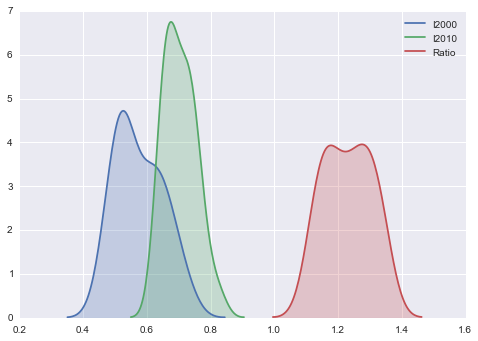

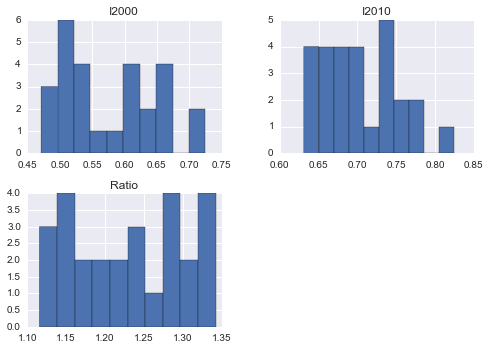

In [10]:
f = plt.figure(14)
idhm_df[["I2000","I2010","Ratio"]].hist(bins=10)
plt.figure()
sns.kdeplot(idhm_df["I2000"], shade=True);
sns.kdeplot(idhm_df["I2010"], shade=True);
sns.kdeplot(idhm_df["Ratio"], shade=True);

### Testando hipótese

#### A diferença média entre os IDHs de 2000 e 2010 é estatisticamente significativa?

In [11]:
ttest_rel(idhm_df['I2000'], idhm_df['I2010'])

(-24.939064182558965, 1.1042795294978112e-19)

In [12]:
import scipy  
import scikits.bootstrap as bootstrap
  
# compute 95% confidence intervals around the mean  
CIs00 = bootstrap.ci(data=idhm_df["I2000"])  
CIs10 = bootstrap.ci(data=idhm_df["I2010"])
CIsR  = bootstrap.ci(data=idhm_df["Ratio"])

print("IDHM 2000 mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs00)))
print("IDHM 2010 mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs10)))
print("IDHM ratio mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIsR)))

IDHM 2000 mean 95% confidence interval. Low=0.550	High=0.605
IDHM 2010 mean 95% confidence interval. Low=0.687	High=0.724
IDHM ratio mean 95% confidence interval. Low=1.204	High=1.258


In [13]:
CIs00 = bootstrap.ci(data=idhm_df["I2000"], statfunction=scipy.median)  
CIs10 = bootstrap.ci(data=idhm_df["I2010"], statfunction=scipy.median)
CIsR  = bootstrap.ci(data=idhm_df["Ratio"], statfunction=scipy.median)

print("IDHM 2000 median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs00)))
print("IDHM 2010 median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs10)))
print("IDHM ratio median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIsR)))

IDHM 2000 median 95% confidence interval. Low=0.518	High=0.613
IDHM 2010 median 95% confidence interval. Low=0.665	High=0.729
IDHM ratio median 95% confidence interval. Low=1.171	High=1.282


A resposta de diversos testes, para um nível de 5% de significância, mostra que há fortes evidências que **sim**.

### Montando percentual de impacto da administração de cada partido em cada Estado da Federação.

In [14]:
state_parties = pd.DataFrame({"Estado":idhm_df.Estado,"PT":np.repeat(0.0,27),"PSDB":np.repeat(0.0,27),"Outros":np.repeat(0.0,27)})

In [15]:
st_pa = np.array([
        [u"Distrito Federal", 0.0, 0.0, 1.0],
        [u"São Paulo", 0.0, 0.925, 0.075],
        [u"Santa Catarina", 0.0, 0.0, 1.0],
        [u"Rio de Janeiro", 0.4, 0.0, 0.6],
        [u"Paraná", 0.0, 0.0, 1.0],
        [u"Rio Grande do Sul", 0.2, 0.4, 0.4],
        [u"Espírito Santo", 0.0, 0.2, 0.8],
        [u"Goiás", 0.0, 0.6, 0.4],
        [u"Minas Gerais", 0.0, 0.8, 0.2],
        [u"Mato Grosso do Sul", 0.0, 0.6, 0.4],
        [u"Mato Grosso", 0.0, 0.2, 0.8],
        [u"Amapá", 0.075, 0.0, 0.925],
        [u"Roraima", 0.275, 0.4, 0.325], # double check
        [u"Tocantins", 0.0, 0.2, 0.8], 
        [u"Rondônia", 0.0, 0.4, 0.6],
        [u"Rio Grande do Norte", 0.0, 0.0, 1.0],
        [u"Ceará", 0.6, 0.0, 0.4],
        [u"Amazonas", 0.0, 0.0, 1.0],
        [u"Pernambuco", 0.0, 0.0, 1.0],
        [u"Sergipe", 0.4, 0.2, 0.4],
        [u"Acre", 1.0, 0.0, 0.0],
        [u"Bahia", 0.4, 0.0, 0.6],
        [u"Paraíba", 0.0, 0.55, 0.45],
        [u"Piauí", 0.8, 0.0, 0.2],
        [u"Pará", 0.4, 0.6, 0.0],
        [u"Maranhão", 0.0, 0.0, 1.0],
        [u"Alagoas", 0.0, 0.0, 1.0],
       ])

Sanity checks

In [16]:
np.float64(st_pa[:,1:]).sum(axis=1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [17]:
np.float64(st_pa[:,1:]).sum(axis=0)

array([  4.55 ,   6.075,  16.375])

In [18]:
state_parties_df = pd.DataFrame({"Estado":st_pa[:,0],"PSDB":np.float64(st_pa[:,2]),"PT":np.float64(st_pa[:,1]),"Outros":np.float64(st_pa[:,3])})

In [19]:
state_parties_df

,Estado,Outros,PSDB,PT
0,Distrito Federal,1.000,0.000,0.000
1,São Paulo,0.075,0.925,0.000
2,Santa Catarina,1.000,0.000,0.000
3,Rio de Janeiro,0.600,0.000,0.400
4,Paraná,1.000,0.000,0.000
5,Rio Grande do Sul,0.400,0.400,0.200
6,Espírito Santo,0.800,0.200,0.000
7,Goiás,0.400,0.600,0.000
8,Minas Gerais,0.200,0.800,0.000
9,Mato Grosso do Sul,0.400,0.600,0.000


In [20]:
df = idhm_df.merge(state_parties_df, on="Estado")
df

,Estado,I2000,I2010,Ratio,idh_level_2000,Outros,PSDB,PT
0,Distrito Federal,0.725,0.824,1.136552,ALTO,1.000,0.000,0.000
1,São Paulo,0.702,0.783,1.115385,ALTO,0.075,0.925,0.000
2,Santa Catarina,0.674,0.774,1.148368,ALTO,1.000,0.000,0.000
3,Rio de Janeiro,0.664,0.761,1.146084,ALTO,0.600,0.000,0.400
4,Paraná,0.650,0.749,1.152308,ALTO,1.000,0.000,0.000
5,Rio Grande do Sul,0.664,0.746,1.123494,ALTO,0.400,0.400,0.200
6,Espírito Santo,0.640,0.740,1.156250,ALTO,0.800,0.200,0.000
7,Goiás,0.615,0.735,1.195122,ALTO,0.400,0.600,0.000
8,Minas Gerais,0.624,0.731,1.171474,ALTO,0.200,0.800,0.000
9,Mato Grosso do Sul,0.613,0.729,1.189233,ALTO,0.400,0.600,0.000


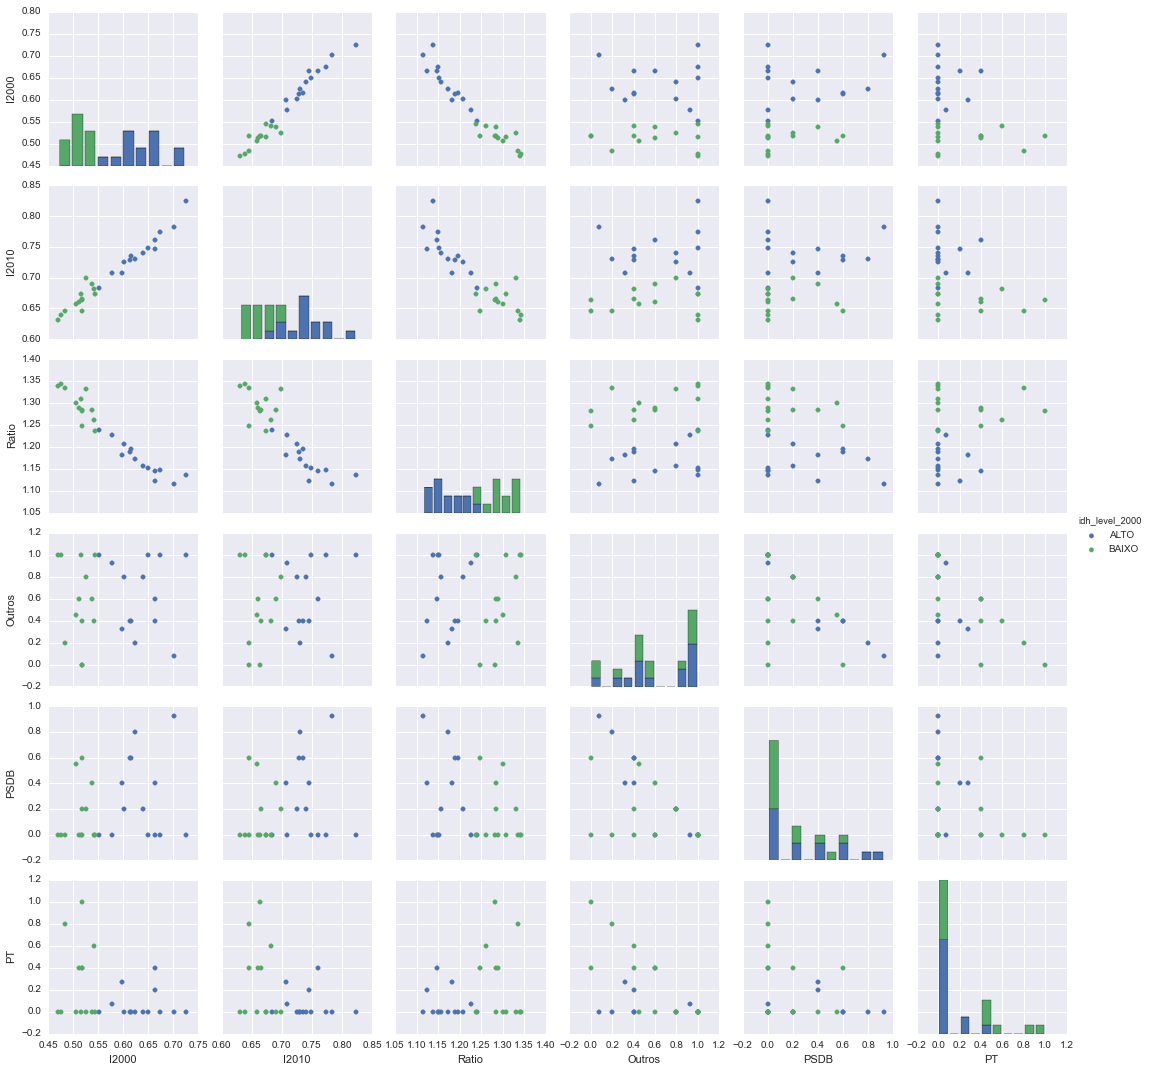

In [21]:
sns.set()
sns.pairplot(df, hue="idh_level_2000", size=2.5)

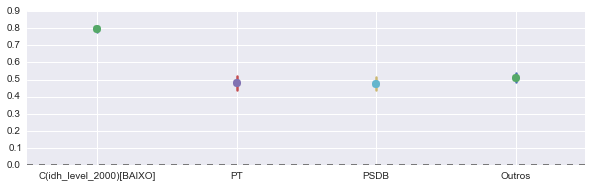

In [22]:
sns.coefplot("Ratio ~ PT + PSDB + Outros + C(idh_level_2000) - 1", df, palette="Set1");

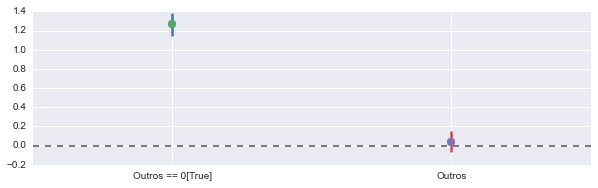

In [23]:
sns.coefplot("Ratio ~ Outros==0 + Outros - 1", df, palette="Set1");

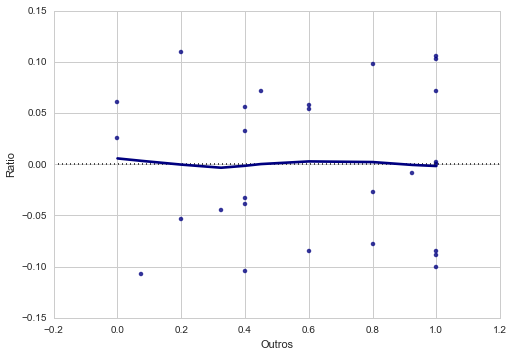

In [24]:
sns.set(style="whitegrid")
sns.residplot(df.Outros,df.Ratio, color="navy", lowess=True, order=1)

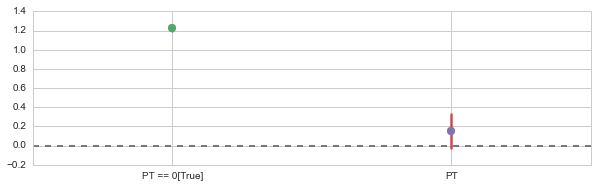

In [25]:
sns.coefplot("Ratio ~ PT==0 + PT - 1", df, palette="Set1");

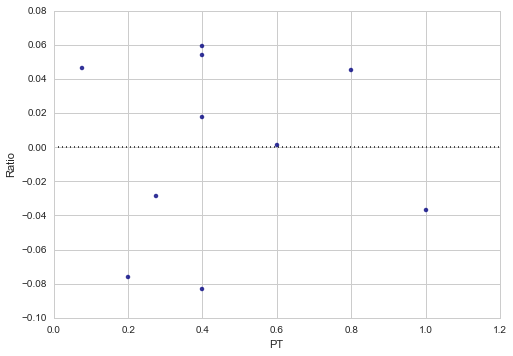

In [26]:
sns.set(style="whitegrid")
sns.residplot(df[df.PT>0].PT, df[df.PT>0].Ratio, color="navy", order=1)

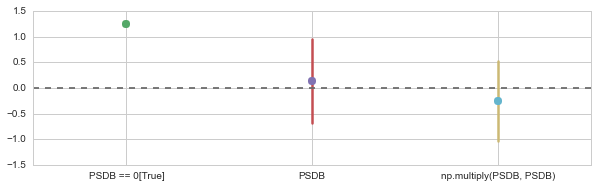

In [27]:
sns.coefplot("Ratio ~ PSDB==0 + PSDB + np.multiply(PSDB, PSDB) - 1", df, palette="Set1");

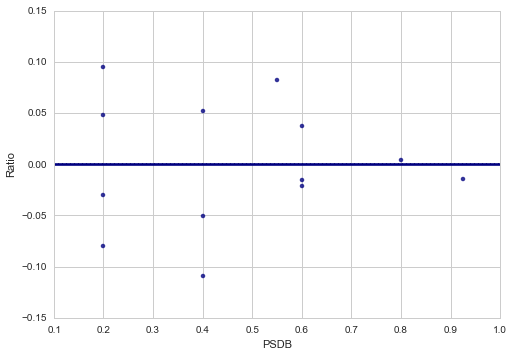

In [28]:
sns.set(style="whitegrid")
sns.residplot(df[df.PSDB>0].PSDB, df[df.PSDB>0].Ratio, color="navy", lowess=True, order=2)

### Impacto por partido ou nível do IDH-M em 2000

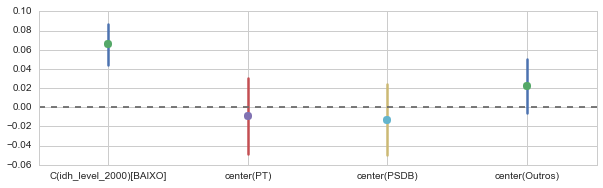

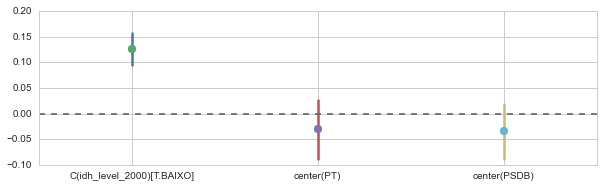

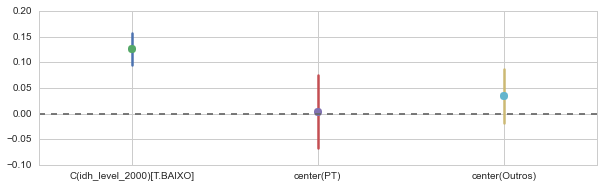

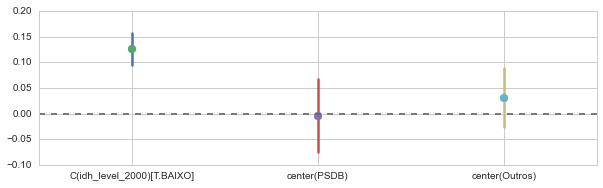

In [29]:
sns.coefplot("center(Ratio) ~ center(PT) + center(PSDB) + center(Outros) + C(idh_level_2000) -1", df, palette="Set1");
sns.coefplot("center(Ratio) ~ center(PT) + center(PSDB) + C(idh_level_2000)", df, palette="Set1");
sns.coefplot("center(Ratio) ~ center(PT) + center(Outros) + C(idh_level_2000)", df, palette="Set1");
sns.coefplot("center(Ratio) ~ center(PSDB) + center(Outros) + C(idh_level_2000)", df, palette="Set1");

In [30]:
formula = "center(Ratio) ~ center(PT) + center(PSDB) + center(Outros) + C(idh_level_2000) -1"
model = ols(formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          center(Ratio)   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     28.17
Date:                Thu, 07 May 2015   Prob (F-statistic):           7.03e-08
Time:                        20:02:17   Log-Likelihood:                 53.727
No. Observations:                  27   AIC:                            -99.45
Df Residuals:                      23   BIC:                            -94.27
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
C(idh_level_2000)[ALTO]     -0.0608      0.010     -6.047      0.000        -0.082    -0.040
C(idh_level_2000)[BAIXO]     0.0655      0.010      6.253      0.000         0.044     0.087
center(PT)                  -0.0089      0.019     -0.463      0.648        -0.048     0.031
center(PSDB)                -0.0130      0.018     -0.719      0.479        -0.050     0.024
center(Outros)               0.0218      0.014      1.600      0.123        -0.006     0.050
==============================================================================
Omnibus:                        1.722   Durbin-Watson:                   1.385
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.085
Skew:                          -0.142   Prob(JB):                        0.581
Kurtosis:                       2.060   Cond. No.                     3.24e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.36e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Não foi possível observar diferença significantiva entre os partidos.**

### Modelo estratificado por nível do IDH em 2000

Será que existe diferença para quem está acima da média de IDH?

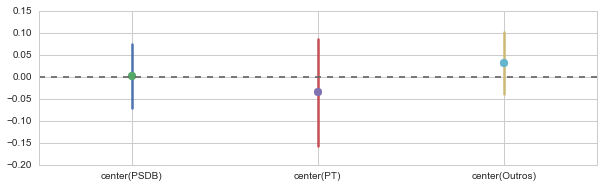

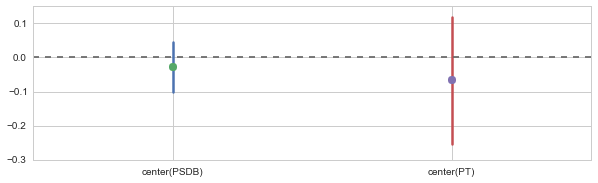

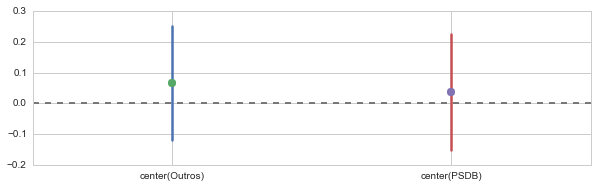

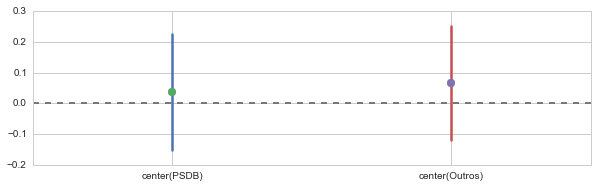

In [31]:
sns.coefplot("center(Ratio) ~ center(PSDB) + center(PT) + center(Outros)",df[df.idh_level_2000=="ALTO"], palette="Set1");
sns.coefplot("center(Ratio) ~ center(PSDB) + center(PT)", df[df.idh_level_2000=="ALTO"], palette="Set1");
sns.coefplot("center(Ratio) ~ center(Outros) + center(PSDB)", df[df.idh_level_2000=="ALTO"], palette="Set1");
sns.coefplot("center(Ratio) ~ center(PSDB) + center(Outros)", df[df.idh_level_2000=="ALTO"], palette="Set1");

In [32]:
formula = "scale(Ratio) ~ PT + PSDB"
model = ols(formula, df[df.idh_level_2000=="ALTO"]).fit()
model.summary()

/home/regis/Documents/DataAnalysis/lib/python3.4/site-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           scale(Ratio)   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                 -0.066
Method:                 Least Squares   F-statistic:                    0.5955
Date:                Thu, 07 May 2015   Prob (F-statistic):              0.568
Time:                        20:02:18   Log-Likelihood:                -19.146
No. Observations:                  14   AIC:                             44.29
Df Residuals:                      11   BIC:                             46.21
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.3609      0.441      0.819      0.430        -0.609     1.331
PT            -1.8409      2.333     -0.789      0.447        -6.976     3.294
PSDB          -0.8009      0.918     -0.873      0.402        -2.821     1.219
==============================================================================
Omnibus:                        4.531   Durbin-Watson:                   0.353
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                1.322
Skew:                           0.105   Prob(JB):                        0.516
Kurtosis:                       1.509   Cond. No.                         8.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Não foi possível identificar diferença nesse caso também.


Será que existe diferença então para quem está *abaixo* da média de IDH?

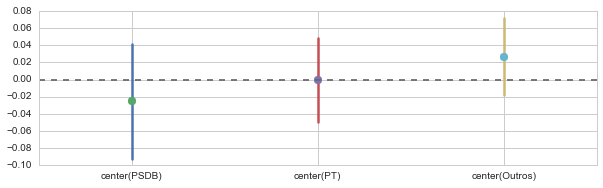

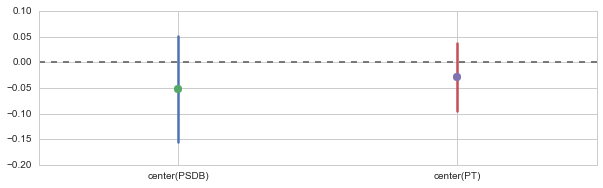

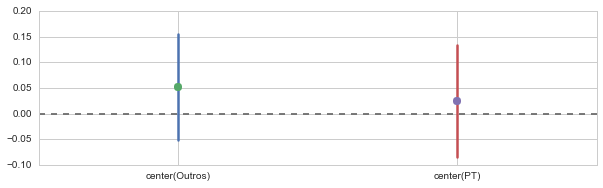

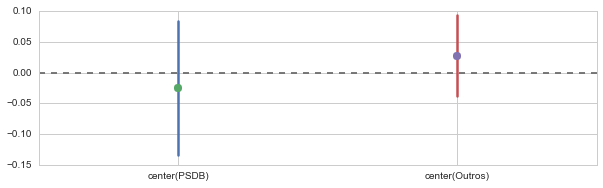

In [33]:
sns.coefplot("center(Ratio) ~ center(PSDB) + center(PT) + center(Outros)",df[df.idh_level_2000=="BAIXO"], palette="Set1");
sns.coefplot("center(Ratio) ~ center(PSDB) + center(PT)", df[df.idh_level_2000=="BAIXO"], palette="Set1");
sns.coefplot("center(Ratio) ~ center(Outros) + center(PT)", df[df.idh_level_2000=="BAIXO"], palette="Set1");
sns.coefplot("center(Ratio) ~ center(PSDB) + center(Outros)", df[df.idh_level_2000=="BAIXO"], palette="Set1");

In [34]:
formula = "scale(Ratio) ~ PT + PSDB"
model = ols(formula, df[df.idh_level_2000=="BAIXO"], ).fit()
model.summary()

/home/regis/Documents/DataAnalysis/lib/python3.4/site-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           scale(Ratio)   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.8739
Date:                Thu, 07 May 2015   Prob (F-statistic):              0.447
Time:                        20:02:19   Log-Likelihood:                -17.399
No. Observations:                  13   AIC:                             40.80
Df Residuals:                      10   BIC:                             42.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4632      0.461      1.005      0.338        -0.563     1.490
PT            -0.8259      0.888     -0.930      0.374        -2.804     1.152
PSDB          -1.5632      1.384     -1.129      0.285        -4.648     1.521
==============================================================================
Omnibus:                        2.725   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.256   Jarque-Bera (JB):                1.097
Skew:                          -0.702   Prob(JB):                        0.578
Kurtosis:                       3.236   Cond. No.                         5.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Também não foi possível identificar diferença estatisticamente relevante.

### Quais estados possuem diferença significativa?

Comparando 2010 com 2000

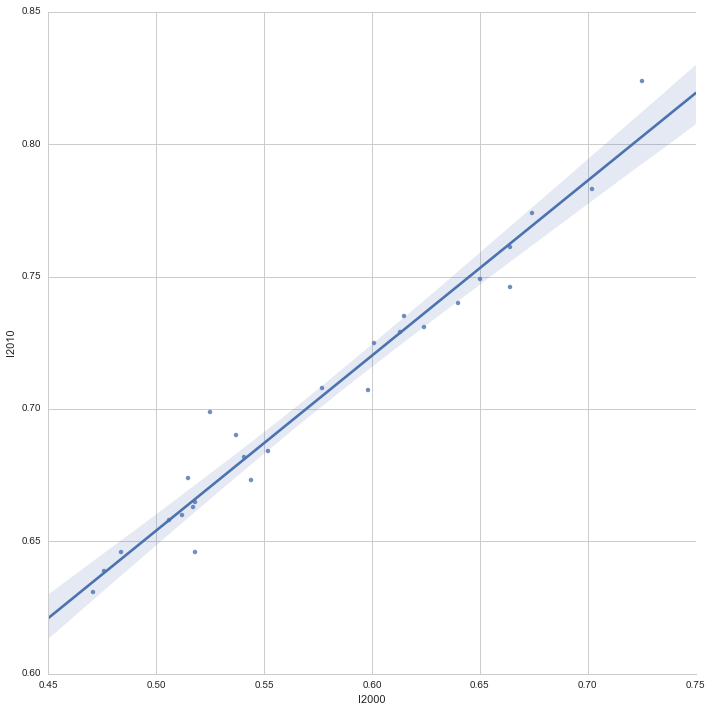

In [100]:
sns.lmplot("I2000", "I2010", data=df, legend=True, size=10, n_boot=10000, ci=95)

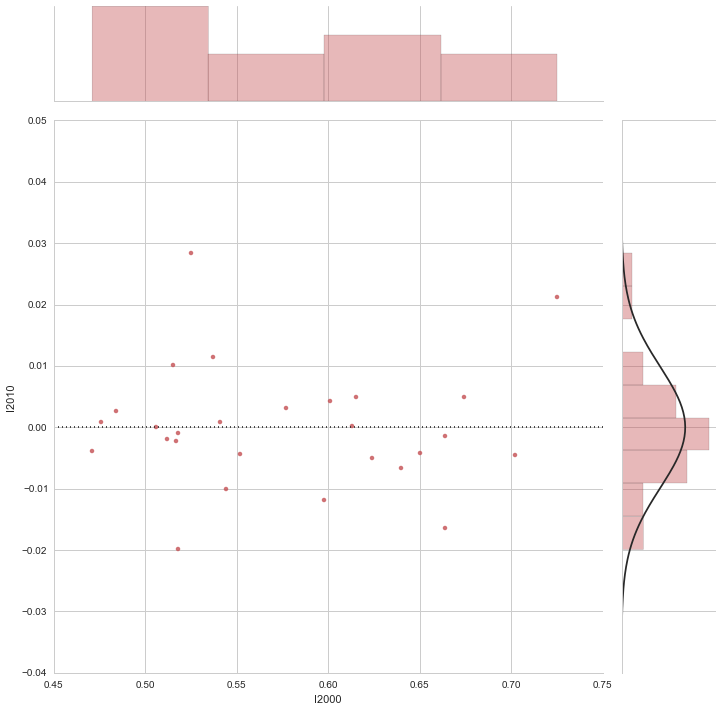

In [89]:
sns.jointplot("I2000", "I2010", data=df, kind='resid',color=sns.color_palette()[2], size=10)

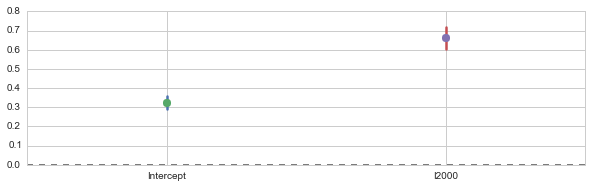

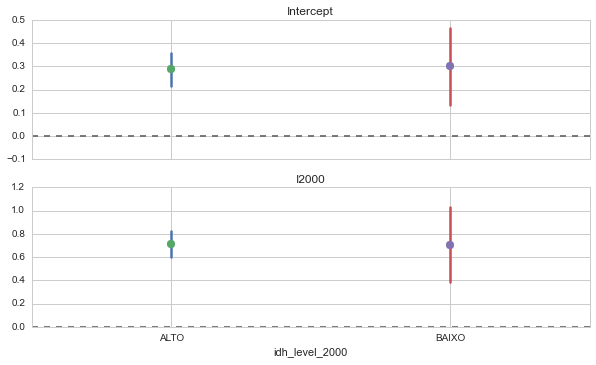

In [65]:
sns.coefplot("I2010 ~ I2000", data=df, intercept=True)
sns.coefplot("I2010 ~ I2000", data=df, groupby="idh_level_2000", intercept=True)

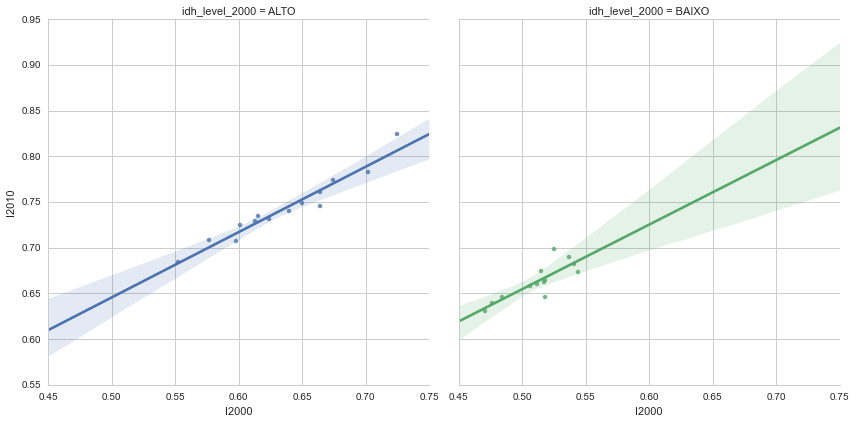

In [80]:
sns.lmplot("I2000", "I2010", data=df, hue="idh_level_2000", col="idh_level_2000", legend=True, size=6, n_boot=10000, ci=99)

In [103]:
md = ols("I2010 ~ I2000", df).fit()
print(md.summary())

                            OLS Regression Results                            
Dep. Variable:                  I2010   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     573.1
Date:                Thu, 07 May 2015   Prob (F-statistic):           9.38e-19
Time:                        21:43:13   Log-Likelihood:                 86.333
No. Observations:                  27   AIC:                            -168.7
Df Residuals:                      25   BIC:                            -166.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.3234      0.016     20.157      0.0

In [136]:
rrr = md.get_robustcov_results()
rrp = rrr.outlier_test("fdr_bh", 0.1)
idx = rrp[rrp["fdr_bh(p)"] <= 0.1].index
print("Estados fora da média:\n",df.ix[idx.values])
rrp[rrp["fdr_bh(p)"] <= 0.1]

Estados fora da média:
        Estado  I2000  I2010     Ratio idh_level_2000  Outros  PSDB  PT
13  Tocantins  0.525  0.699  1.331429          BAIXO     0.8   0.2   0


,student_resid,unadj_p,fdr_bh(p)
13,3.402251,0.002345,0.063304


In [96]:
md = mixedlm("I2010 ~ I2000", df, groups=df.idh_level_2000) 
mdf = md.fit() 
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: I2010  
No. Observations:  27      Method:             REML   
No. Groups:        2       Scale:              0.0001 
Min. group size:   13      Likelihood:         78.3365
Max. group size:   14      Converged:          Yes    
Mean group size:   13.5                               
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.316    0.017 18.973 0.000  0.283  0.349
I2000        0.674    0.028 23.677 0.000  0.618  0.730
Intercept RE 0.000                                    



/home/regis/Documents/DataAnalysis/lib/python3.4/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
